In [364]:
#conda activate Geospatial (in terminal)
import requests
import pandas as pd
from io import StringIO
import json 
import csv 
from shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt

In [365]:
# capture data within the tn boarders with longitude and latitude and convert to csv and start the time from 1900 to now
url = 'https://opendata.arcgis.com/datasets/592082987bd5456baab74d70f1bf5d90_0.geojson'

In [366]:
#getting API url and building df
r = requests.get(url)
tn_counties = gpd.read_file(url)
tn_counties[50:70]

,FID,COUNTYNS,GEOID,NAMELSAD,CLASSFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,OBJECTID,Population,Shape__Area,Shape__Length,geometry
50,51,01639765,47101,Lewis County,H1,A,730608074,1031592,+35.5232441,-87.4969827,2479,11944,1.107064e+09,186407.839764,"POLYGON ((-87.65780 35.56069, -87.65779 35.560..."
51,52,01639766,47103,Lincoln County,H1,A,1477169472,990351,+35.1429163,-86.5932976,2480,33550,2.215534e+09,228874.034315,"POLYGON ((-86.83368 35.08233, -86.83368 35.082..."
52,53,01639767,47105,Loudon County,H1,A,593758833,46926070,+35.7374500,-84.3162040,2481,50229,9.744395e+08,235086.652016,"MULTIPOLYGON (((-84.54036 35.61938, -84.54036 ..."
53,54,01639773,47107,McMinn County,H1,A,1114009043,5340572,+35.4244708,-84.6199625,2482,52506,1.689446e+09,211711.878915,"POLYGON ((-84.73652 35.51632, -84.73559 35.517..."
54,55,01639774,47109,McNairy County,H1,A,1457754792,1994987,+35.1752280,-88.5636295,2483,26103,2.189806e+09,207557.062583,"POLYGON ((-88.71649 35.25635, -88.71648 35.256..."
55,56,01639768,47111,Macon County,H1,A,795498386,246690,+36.5377574,-86.0009592,2484,22761,1.234898e+09,150461.152222,"POLYGON ((-85.97249 36.62833, -85.96700 36.628..."
56,57,01639769,47113,Madison County,H1,A,1442905034,3930429,+35.6060563,-88.8334238,2485,98184,2.193637e+09,200091.559116,"POLYGON ((-89.01910 35.67280, -89.01905 35.672..."
57,58,01639770,47115,Marion County,H1,A,1290227365,36501982,+35.1334215,-85.6183990,2486,28306,1.988021e+09,197208.736831,"POLYGON ((-85.54388 35.30238, -85.54187 35.301..."
58,59,01639771,47117,Marshall County,H1,A,972442313,1801922,+35.4683866,-86.7658862,2487,31159,1.472039e+09,230293.227428,"POLYGON ((-86.79076 35.70371, -86.78927 35.704..."
59,60,01639772,47119,Maury County,H1,A,1588021146,6319196,+35.6156963,-87.0777632,2488,84089,2.417805e+09,264497.367108,"POLYGON ((-87.24576 35.72064, -87.24524 35.720..."


In [367]:
# cleaning to just needed columns
tn_counties['county'] = tn_counties['NAMELSAD']
tn_counties = tn_counties[['county','Population','geometry']]

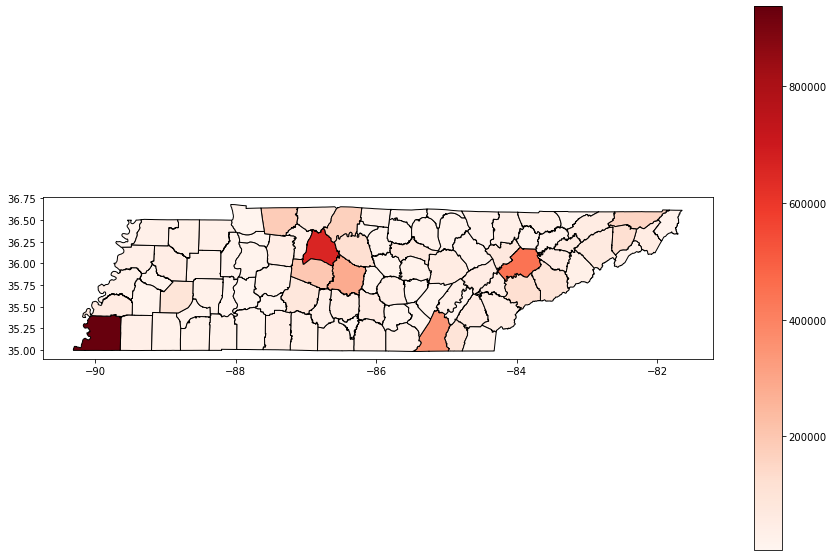

In [368]:
#creating map of population in TN
tn_counties.plot(column = 'Population', figsize=(15, 10),
              edgecolor = 'black',legend = True, cmap = 'Reds')
plt.show()

In [369]:
#bring in geometry of big quakes
outside_tn_quake_df = pd.read_csv('../data/cleaned_outside_tn_earthquake_data.csv')

#subsetting for quakes larger than 3.8 magnitude
big_quakes = outside_tn_quake_df[outside_tn_quake_df['mag']>3.8]

# getting rid of quakes too far from tn border
big_quakes = big_quakes[big_quakes['Unnamed: 0'].isin([10204, 10228, 10229, 10209, 335, 6013, 7003,9884]) == False]

#sorting quakes df by magnitude
big_quakes = big_quakes.sort_values(by = 'mag')

In [370]:
big_quakes.head(50)

,Unnamed: 0,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,...,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,state,date
3780,3780,09:58:43,36.873333,-89.422667,7.81,3.90,mw,65.0,38.0,NaN,...,earthquake,0.18,0.46,0.042,3.0,reviewed,nm,nm,Missouri,2012-02-21
10206,10206,20:06:17,35.000000,-83.500000,NaN,3.90,fa,NaN,NaN,NaN,...,earthquake,NaN,NaN,NaN,NaN,reviewed,ushis,sc,er region,1957-11-24
6219,6219,01:08:21,34.735000,-86.245000,5.00,3.90,mblg,8.0,NaN,NaN,...,earthquake,NaN,NaN,NaN,NaN,reviewed,us,us,Alabama,2001-12-08
9317,9317,04:12:16,36.170000,-89.650000,11.80,3.90,Unknown,NaN,NaN,NaN,...,earthquake,NaN,NaN,NaN,NaN,reviewed,nm,nm,Missouri,1979-06-11
10212,10212,09:02:40,36.000000,-89.500000,NaN,3.90,fa,NaN,NaN,NaN,...,earthquake,NaN,NaN,NaN,NaN,reviewed,ushis,sc,Tennessee,1955-03-29
10211,10211,04:44:16,35.756000,-89.803000,16.00,4.00,fa,NaN,NaN,NaN,...,earthquake,NaN,NaN,NaN,NaN,reviewed,ushis,dg,Tennessee,1956-01-29
5515,5515,11:35:11,36.150167,-89.473500,15.02,4.00,mw,35.0,57.0,0.03105,...,earthquake,0.20,0.60,0.457,9.0,reviewed,nm,nm,Tennessee,2005-06-02
8852,8852,11:53:44,36.030000,-89.180000,22.80,4.00,md,NaN,NaN,NaN,...,earthquake,NaN,NaN,NaN,NaN,reviewed,nm,nm,Tennessee,1981-08-07
5980,5980,12:29:34,36.878833,-88.995833,2.50,4.00,mw,42.0,50.0,0.11840,...,earthquake,1.20,1.30,0.363,5.0,reviewed,nm,nm,Kentucky,2003-06-06
6004,6004,04:56:21,35.945000,-89.916167,23.68,4.00,md,31.0,75.0,0.08369,...,earthquake,0.30,0.60,0.396,15.0,reviewed,nm,nm,Arkansas,2003-04-30


In [371]:
#creating a geometry column
big_quakes['geometry'] = big_quakes.apply(lambda x: Point((float(x.longitude), float(x.latitude))), axis = 1)

In [372]:
#creating a GeoDataFrame
big_quakes = gpd.GeoDataFrame(big_quakes, geometry = big_quakes['geometry'])

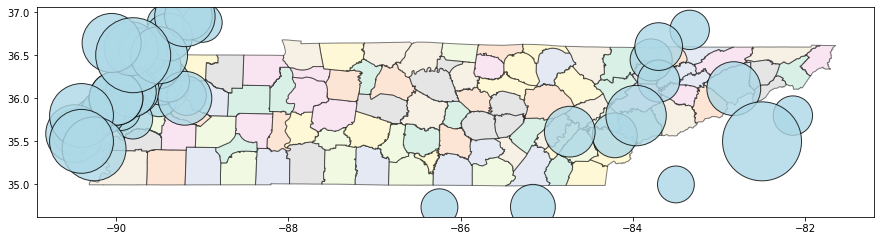

In [373]:
#test
ax = tn_counties['geometry'].plot(figsize = (15,10), edgecolor = 'black', cmap = 'Pastel2', alpha = 0.5)
big_quakes['geometry'].plot(ax = ax, markersize = big_quakes['mag'] ** 5.3, color = 'lightblue', alpha = 0.8, edgecolor = 'black')
plt.show();

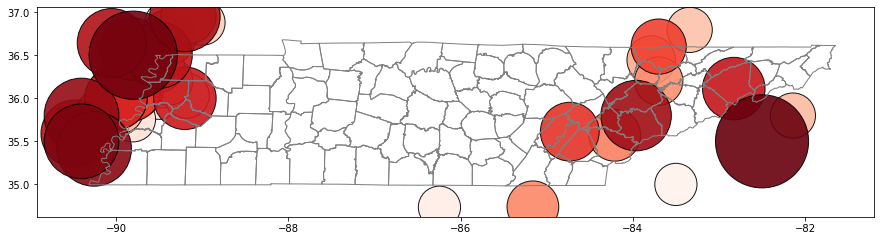

In [374]:
#Plotting Earthquakes on TN Counties (Circles sized and colored by magnitude)
ax = tn_counties['geometry'].boundary.plot(figsize = (15,10), color = 'Gray', linewidth=1)
big_quakes['geometry'].plot(ax = ax, markersize = big_quakes['mag'] ** 5.5, cmap = 'Reds', alpha = 0.9, edgecolor = 'black')
plt.show();

In [375]:
#initializing lists for estimated percent covered
p_100 = ['Lake County', 'Dyer County', 'Crockett County', 'Claiborne County', 'Union County', 'Greene County', 'Knox County', 'Blount County', 'Meigs County']
p_75 = ['Gibson County', 'Rhea County', 'McMinn County']
p_50 = ['Obion County', 'Lauderdale County', 'Grainger County', 'Cooke County', 'Loudon County', 'Roane County', 'Anderson County']
p_25 = ['Tipton County', 'Shelby County', 'Haywood County', 'Unicol County', 'Monroe County', 'Sevier County']

In [376]:
#creating estimated percent covered column
tn_counties['est_percent_covered'] = 0

In [378]:
#filling in correct estimates
for index, row in tn_counties.iterrows():
    if row['county'] in p_100:
        tn_counties['est_percent_covered'][index] = 100
    elif row['county'] in p_75:
        tn_counties['est_percent_covered'][index] = 75
    elif row['county'] in p_50:
        tn_counties['est_percent_covered'][index] = 50
    elif row['county'] in p_25:
        tn_counties['est_percent_covered'][index] = 25

<ipython-input-378-8a9aceea209d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_counties['est_percent_covered'][index] = 50
<ipython-input-378-8a9aceea209d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_counties['est_percent_covered'][index] = 100
<ipython-input-378-8a9aceea209d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_counties['est_percent_covered'][index] = 75
<ipython-input-378-8a9aceea209d>:10: SettingWithCop

In [379]:
tn_counties

,county,Population,geometry,est_percent_covered
0,Anderson County,75430,"POLYGON ((-84.33465 36.03021, -84.33470 36.030...",50
1,Bedford County,45986,"POLYGON ((-86.63521 35.57742, -86.63569 35.577...",0
2,Benton County,16261,"POLYGON ((-88.13691 36.20954, -88.13695 36.209...",0
3,Bledsoe County,13686,"POLYGON ((-85.22651 35.76643, -85.22644 35.766...",0
4,Blount County,125188,"POLYGON ((-84.14252 35.79696, -84.14158 35.797...",100
...,...,...,...,...
90,Wayne County,16897,"POLYGON ((-87.98170 35.28795, -87.98170 35.287...",0
91,Weakley County,34415,"POLYGON ((-88.85145 36.40952, -88.85123 36.409...",0
92,White County,26252,"MULTIPOLYGON (((-85.27432 35.78444, -85.27432 ...",0
93,Williamson County,199456,"POLYGON ((-87.01609 35.99788, -87.01561 35.998...",0


In [388]:
#initiating mag column
tn_counties['mag'] = 0.0

#initiating affected_people column
tn_counties['affected_people'] = tn_counties['Population'] * (tn_counties['est_percent_covered']/100)

In [389]:
#correct mag column above
m_4_1 = ['Lauderdale County', 'Union County', 'Grainger County']
m_4_3 = ['Obion County', 'Claiborne County']
m_4_4 = ['Roane County', 'Rhea County', 'Meigs County', 'McMinn County']
m_4_5 = ['Dyer County', 'Gibson County', 'Crockett County', 'Haywood County', 'Greene County', 'Cooke County', 'Unicol County']
m_4_7 = ['Sevier County', 'Knox County', 'Blount County', 'Loudon County', 'Anderson County']
m_4_8 = ['Tipton County', 'Shelby County']
m_5_1 = ['Lake County']

In [390]:
#filling in correct magnitudes
for index, row in tn_counties.iterrows():
    if row['county'] in m_4_1:
        tn_counties['mag'][index] = 4.1
    elif row['county'] in m_4_3:
        tn_counties['mag'][index] = 4.3
    elif row['county'] in m_4_4:
        tn_counties['mag'][index] = 4.4
    elif row['county'] in m_4_5:
        tn_counties['mag'][index] = 4.5
    elif row['county'] in m_4_7:
        tn_counties['mag'][index] = 4.7
    elif row['county'] in m_4_8:
        tn_counties['mag'][index] = 4.8
    elif row['county'] in m_5_1:
        tn_counties['mag'][index] = 5.1

<ipython-input-390-066316ee2a70>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_counties['mag'][index] = 4.7
<ipython-input-390-066316ee2a70>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_counties['mag'][index] = 4.3
<ipython-input-390-066316ee2a70>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tn_counties['mag'][index] = 4.5
<ipython-input-390-066316ee2a70>:4: SettingWithCopyWarning: 
A value is trying to be set on a c

In [416]:
#making strength and risk number columns
tn_counties['strength'] = 10 ** tn_counties['mag'] 
tn_counties['county_risk_number'] = (tn_counties['affected_people'] * tn_counties['strength'])/ 200000000

In [418]:
tn_counties[tn_counties['county_risk_number']>50]

,county,Population,geometry,est_percent_covered,mag,affected_people,strength,county_risk_number
46,Knox County,444348,"POLYGON ((-84.07291 36.04973, -84.07303 36.049...",100,4.7,444348.0,50118.723363,111.073090
78,Shelby County,937750,"POLYGON ((-90.07434 35.21102, -90.07409 35.212...",25,4.8,234437.5,63095.734448,73.775592



### Use distance formula to find points to build a polygon (circle)

est_percent_covered

affected_people = (populaton * est(% covered)) 

strength = 10 ** mag

county_risk_number = (affected_people * strength) / 1000000

#calculate for all earthquakes that hit county

#only keep highest risk number for each county

import plotly.express as px

fig = px.choropleth(tn_counties, geojson = 'geometry', locations='fips', color='unemp',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           scope="usa",
                           labels={'unemp':'unemployment rate'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()